In [122]:
import pandas as pd
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from seaborn import heatmap
from scipy.stats import norm, ks_2samp
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Task 1

## Part 1

### 1.

#### a.

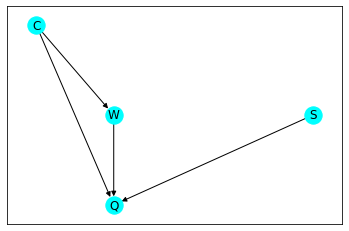

In [38]:
G = nx.DiGraph()

G.add_edges_from([
    ('C', 'Q'),
    ('W', 'Q'),
    ('S', 'Q'),
    ('C', 'W')
])

pos = graphviz_layout(G, prog='dot')
nx.draw_networkx(G, node_color='cyan', pos=pos)

#### b.

$$P(Q, W, S, C) \propto P(Q | W, S, C) \cdot P(W | C) \cdot P(S) \cdot P(C)$$

### 2.

<AxesSubplot:>

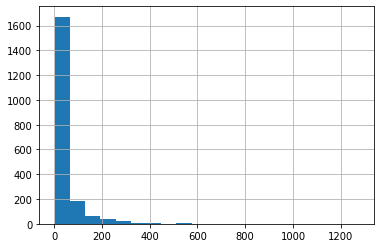

In [39]:
df_qc_train = pd.read_csv('QualityControlTraining.csv')
df_qc_train.Wait_Time.hist(bins=20)

The histogram for wait time is heavily skewed right

<AxesSubplot:>

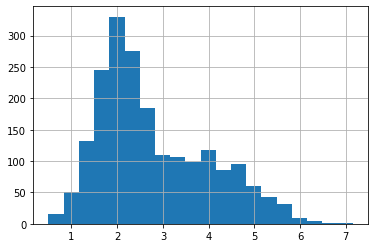

In [40]:
np.log(df_qc_train.Wait_Time).hist(bins=20)

This histogram appears to be a mixture of two gaussians, where the first is centered around 2 with small variance and the second is centered around 3.5 with larger variance.

### 3.

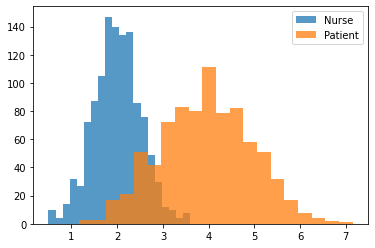

In [41]:
lg_wait_time_nurse = np.log(df_qc_train[df_qc_train.Collection_Method == 'Nurse'].Wait_Time)
lg_wait_time_patient = np.log(df_qc_train[df_qc_train.Collection_Method == 'Patient'].Wait_Time)

bins = 20
alpha = .75

plt.hist(lg_wait_time_nurse, bins=bins, alpha=alpha)
plt.hist(lg_wait_time_patient, bins=bins, alpha=alpha)
plt.legend(['Nurse', 'Patient'])

In [42]:
mean, std = lg_wait_time_nurse.mean(), lg_wait_time_nurse.std()
print(f'Nurse stats: mean = {mean:.3f}, std = {std:.3f}')

Nurse stats: mean = 1.997, std = 0.519


### 4.

#### a.

For each $C \in \{P, N\}$,
$$Q | C, W, S \sim \mathcal{N}(\mu_C(W,S), \sigma_C),$$
where
\begin{align*}
    \mu_C(w, s) &= \begin{bmatrix}1 & \log(w) & s\end{bmatrix}^\top a_C & \text{for some fixed } a_C &\in \mathbb{R}^3, \\
    \sigma_C &\in \mathbb{R} \text{ is fixed}
\end{align*}

#### b.

For all $i\in I_P$,
$$P_{\theta_P}(q_i, w_i, s_i, \text{P}) = P_{\theta_P}(q_i | w_i, s_i, \text{P}) \cdot P(w_i | \text{P}) \cdot P(s_i) \cdot P(\text{P}) $$

#### c.
For all $i \in I_P$,
\begin{align*}
P_{\theta_P}(q_i, w_i, s_i, \text{P}) &\propto_{\theta_P} P_{\theta_P}(q_i | w_i, s_i, \text{P}) \\
&\propto_{\theta_P} \frac{1}{\sigma_P} \exp\left( -\frac{1}{2\sigma_P^2} \left(q_i - \begin{bmatrix}1 & \log(w_i) & s_i\end{bmatrix}^\top a_P \right)^2 \right) \\
\Rightarrow \theta^*_P &= \underset{\sigma, a}{\arg\max} \; \sigma^{-N} \exp\left( -\frac{1}{2\sigma^2} \sum_{i\in I_P} \left(q_i - \begin{bmatrix}1 & \log(w_i) & s_i\end{bmatrix}^\top a \right)^2 \right) \\
&= \underset{\sigma, a}{\arg\min} \; N \log \sigma + \frac{1}{2\sigma^2} ||q-Z_P a||_2^2 \\
&= \underset{\sigma, a}{\arg\min} \; N \log \sigma^2 + \frac{1}{\sigma^2} ||q-Z_P a||_2^2
\end{align*}

where $Z_P \in \mathbb{R}^{N\times 3}$ is the data matrix for when the collection method is Patient, i.e. $Z_i = \begin{bmatrix} 1 & \log w_i & s_i \end{bmatrix}$ for all $i\in[I_P]$. We can break this into a sequence of two optimization problems:
\begin{align*}
    a_P^* &= \underset{a}{\arg\min}\; ||q-Z_P a||_2^2 \\
    \sigma_P^* &= \underset{\sigma}{\arg\min}\; N \log \sigma^2 + \frac{\epsilon_P^*}{\sigma^2}
\end{align*}

where $\epsilon_P^*$ be the optimal objective value associated with $a_P^*$. Notice that the first problem is just least squares, which as the closed form solution
$$a_P^* = (Z_P^T Z_P)^{-1} Z_P^T q$$
The second problem can also be solved analytically using single-variable calculus:

\begin{align*}
    \frac{\text{d}}{\text{d} \sigma} \left( N \log \sigma^2 + \frac{\epsilon}{\sigma^2} \right) &= \frac{2N}{\sigma} - \frac{2\epsilon}{\sigma^3} = 0 \\
    \Rightarrow N - \frac{\epsilon}{\sigma^2} &= 0 \\
    \Rightarrow \sigma^2 &= \frac{\epsilon}{N}
\end{align*}

Thus $(\sigma_P^*)^2 = \epsilon_P^* / N$.

In [43]:
def estimate_Q_params(c):
    df_qc_train_c = df_qc_train[df_qc_train.Collection_Method == c]
    q = df_qc_train_c.Quality_Score
    w = df_qc_train_c.Wait_Time
    s = df_qc_train_c.Storage_Temperature

    N = len(df_qc_train_c)

    Z = np.stack(
        [np.ones(N), np.log(w), s], 
        axis=1
    )

    a = np.linalg.solve(Z.T @ Z, Z.T @ q)
    b = q - Z@a
    eps = b@b
    sigma_sq = eps / N

    return sigma_sq, a


q = df_qc_train.Quality_Score
w = df_qc_train.Wait_Time
s = df_qc_train.Storage_Temperature

sigma_sq, a = estimate_Q_params('Patient')

var_print = f'{sigma_sq:.3f}'
a_print = [f'{x:.3f}' for x in a]

print('estimated parameters:')
print('var =', var_print)
print(f'a =', a_print)

estimated parameters:
var = 4.055
a = ['-9.092', '-1.916', '-2.066']


#### d.

In [44]:
df_qc_train_patient = df_qc_train[df_qc_train.Collection_Method == 'Patient'].copy()
df_qc_train_patient['Lg_Wait_Time'] = np.log(df_qc_train_patient.Wait_Time)
lg_wait_time_mean = df_qc_train_patient.Lg_Wait_Time.mean()
storage_time_mean = df_qc_train_patient.Storage_Temperature.mean()

wait_time_mask = df_qc_train_patient.Lg_Wait_Time.between(lg_wait_time_mean - 0.05, lg_wait_time_mean + 0.05)
storage_time_mask = df_qc_train_patient.Storage_Temperature.between(storage_time_mean - 0.05, storage_time_mean + 0.05)

sigma = df_qc_train_patient[wait_time_mask & storage_time_mask].Quality_Score.std()
print(f'var = {sigma ** 2:.3f}')

var = 4.685


This variance is close to what we computed in part c, with an error of about $\frac{4.685 - 4.055}{4.055} = 15.536\%$

### 5.

\begin{align*}
    \underset{C}{\arg \max}\; P(C | W, S, Q) &= \underset{C}{\arg \max}\; P(C, W, S, Q) \\
    &= \underset{C}{\arg \max}\; P(Q | W, S, C) \cdot P(W | C) \cdot P(C)
\end{align*}

In [45]:
# estimate parameters for each class
param_estimates = {}
for c in ['Patient', 'Nurse']:
    param_estimates[c] = {}
    df_qc_train_c = df_qc_train[df_qc_train.Collection_Method == c]

    param_estimates[c]['prior'] = len(df_qc_train_c) / len(df_qc_train)

    Q_sigma_sq, Q_a = estimate_Q_params(c)
    param_estimates[c]['Q_a'] = Q_a
    param_estimates[c]['Q_sigma_sq'] = Q_sigma_sq

    lg_W = np.log(df_qc_train_c.Wait_Time)
    param_estimates[c]['lgW_mu'] = lg_W.mean()
    param_estimates[c]['lgW_sigma'] = lg_W.std()



def pdf_Q(q, w, s, c):
    '''q, w, s, are columns from the df; c is a fixed class;
    computes densities of q | w, s, c for each row; vectorized
    '''
    Z = np.stack(
        [np.ones(len(q)), np.log(w), s], 
        axis=1
    )
    sigma_sq = param_estimates[c]['Q_sigma_sq']
    a = param_estimates[c]['Q_a']
    b = q - Z@a
    return np.exp(-b*b / (2*sigma_sq)) / np.sqrt(sigma_sq)



def compute_scores(q, w, s, c):
    '''q, w, s, are columns from the df; c is a fixed class;
    computes MAP scores for each row assuming class c; vecotrized
    '''
    Q_density = pdf_Q(q, w, s, c)

    W_mu = param_estimates[c]['lgW_mu']
    W_sigma = param_estimates[c]['lgW_sigma']
    W_density = norm(loc=W_mu, scale=W_sigma).pdf(np.log(w))

    prior = param_estimates[c]['prior']

    return Q_density * W_density * prior

In [46]:
q = df_qc_train.Quality_Score
w = df_qc_train.Wait_Time
s = df_qc_train.Storage_Temperature

patient_scores = compute_scores(q, w, s, 'Patient')
nurse_scores = compute_scores(q, w, s, 'Nurse')

# for each row, prediction is class with higher score
df_qc_predict = df_qc_train.copy()
df_qc_predict['Prediction'] = (patient_scores > nurse_scores)
df_qc_predict.Prediction.replace({True: 'Patient', False: 'Nurse'}, inplace=True)

# rows where prediction is incorrect
df_qc_predict[df_qc_predict.Collection_Method != df_qc_predict.Prediction]

,Collection_Method,Wait_Time,Storage_Temperature,Quality_Score,Prediction
447,Patient,67.721012,-9.491731,10.405145,Nurse
1372,Patient,9.676858,-8.666114,9.787584,Nurse
1566,Patient,30.885939,-10.357828,11.130817,Nurse
1779,Patient,49.562768,-8.989160,9.229951,Nurse
1801,Patient,9.447169,-9.905472,10.931693,Nurse


In [47]:
first_row = df_qc_train.iloc[0]
print(first_row, '\n')

c,w,s,q = first_row
w = np.array([w])
s = np.array([s])
q = np.array([q])

patient_score = compute_scores(q, w, s, 'Patient')
nurse_score = compute_scores(q, w, s, 'Nurse')

print(f'patient score: {patient_score.item():.5f}')
print(f'nurse score: {nurse_score.item():.5f}')
print()

print('since nurse score > patient score, we predict that this sample was collected by a nurse (which happens to be correct).')

Collection_Method          Nurse
Wait_Time               4.763624
Storage_Temperature    -10.82688
Quality_Score          14.979513
Name: 0, dtype: object 

patient score: 0.00030
nurse score: 0.60541

since nurse score > patient score, we predict that this sample was collected by a nurse (which happens to be correct).


### 6.

In [48]:
df_qc = pd.read_csv('QualityControl.csv').drop('Unnamed: 0', axis=1)

def p_val(row):
    c, w, s, = row

    a = param_estimates[c]['Q_a']
    sigma_sq = param_estimates[c]['Q_sigma_sq']

    mu = a @ np.array([1, np.log(w), s])
    std = np.sqrt(sigma_sq)
    return norm(loc=mu, scale=std).cdf(0)

p_vals = df_qc.apply(p_val, axis=1)
df_qc_poor = df_qc[p_vals > .05].copy()
df_qc_poor['p_val'] = p_vals

print('poor quality samples:')
df_qc_poor

poor quality samples:


,Collection_Method,Wait_Time,Storage_Temperature,p_val
9,Patient,67.213921,-9.108656,0.204365
45,Patient,359.243754,-9.270181,0.726693
147,Patient,144.947799,-9.069125,0.478301
151,Patient,62.146447,-9.290589,0.138439
199,Patient,115.896734,-9.962477,0.118257
211,Patient,110.402176,-9.945948,0.112566
223,Patient,73.460547,-8.959942,0.277928
229,Patient,20.716883,-8.147960,0.168460
278,Patient,117.148010,-8.825812,0.497054
346,Patient,33.120764,-8.407036,0.217799


In [127]:
first_row = df_qc.iloc[0]
print(first_row, '\n')

a = param_estimates[c]['Q_a']
var = param_estimates[c]['Q_sigma_sq']

a_print = [f'{x:.3f}' for x in a]
var_print = f'{var:.3f}'

print('Q|C,W,S parameters:')
print(f'a =', a_print)
print('var =', var_print)
print()

c,w,s = first_row

mu = a @ np.array([1, np.log(w), s])
std = np.sqrt(sigma_sq)
print('Q|C,W,S mean and std:')
print(f'mu = {mu:.3f}')
print(f'std = {std:.3f}')
print()

p_val = norm(loc=mu, scale=std).cdf(0)
print(f'P(Q < 0 | C,W,S) = {p_val:.3f}')

Collection_Method        Patient
Wait_Time              70.023933
Storage_Temperature   -10.570253
Name: 0, dtype: object 

Q|C,W,S parameters:
a = ['-5.111', '-1.022', '-2.013']
var = 0.267

Q|C,W,S mean and std:
mu = 11.823
std = 2.014

P(Q < 0 | C,W,S) = 0.000


In [50]:
df_qc_good = df_qc[p_vals < .05]
df_qc_good

,Collection_Method,Wait_Time,Storage_Temperature
0,Patient,70.023933,-10.570253
1,Nurse,3.148633,-8.892279
2,Nurse,10.057289,-11.114723
3,Nurse,13.124937,-10.623559
4,Nurse,5.276018,-8.769540
...,...,...,...
395,Patient,31.725869,-11.327799
396,Nurse,4.722072,-10.423691
397,Patient,32.629223,-10.003274
398,Nurse,13.076011,-11.057704


## Part 2

In [2]:
df_abundance = pd.read_csv('MicrobeAbundance.csv').drop('Unnamed: 0', axis=1)

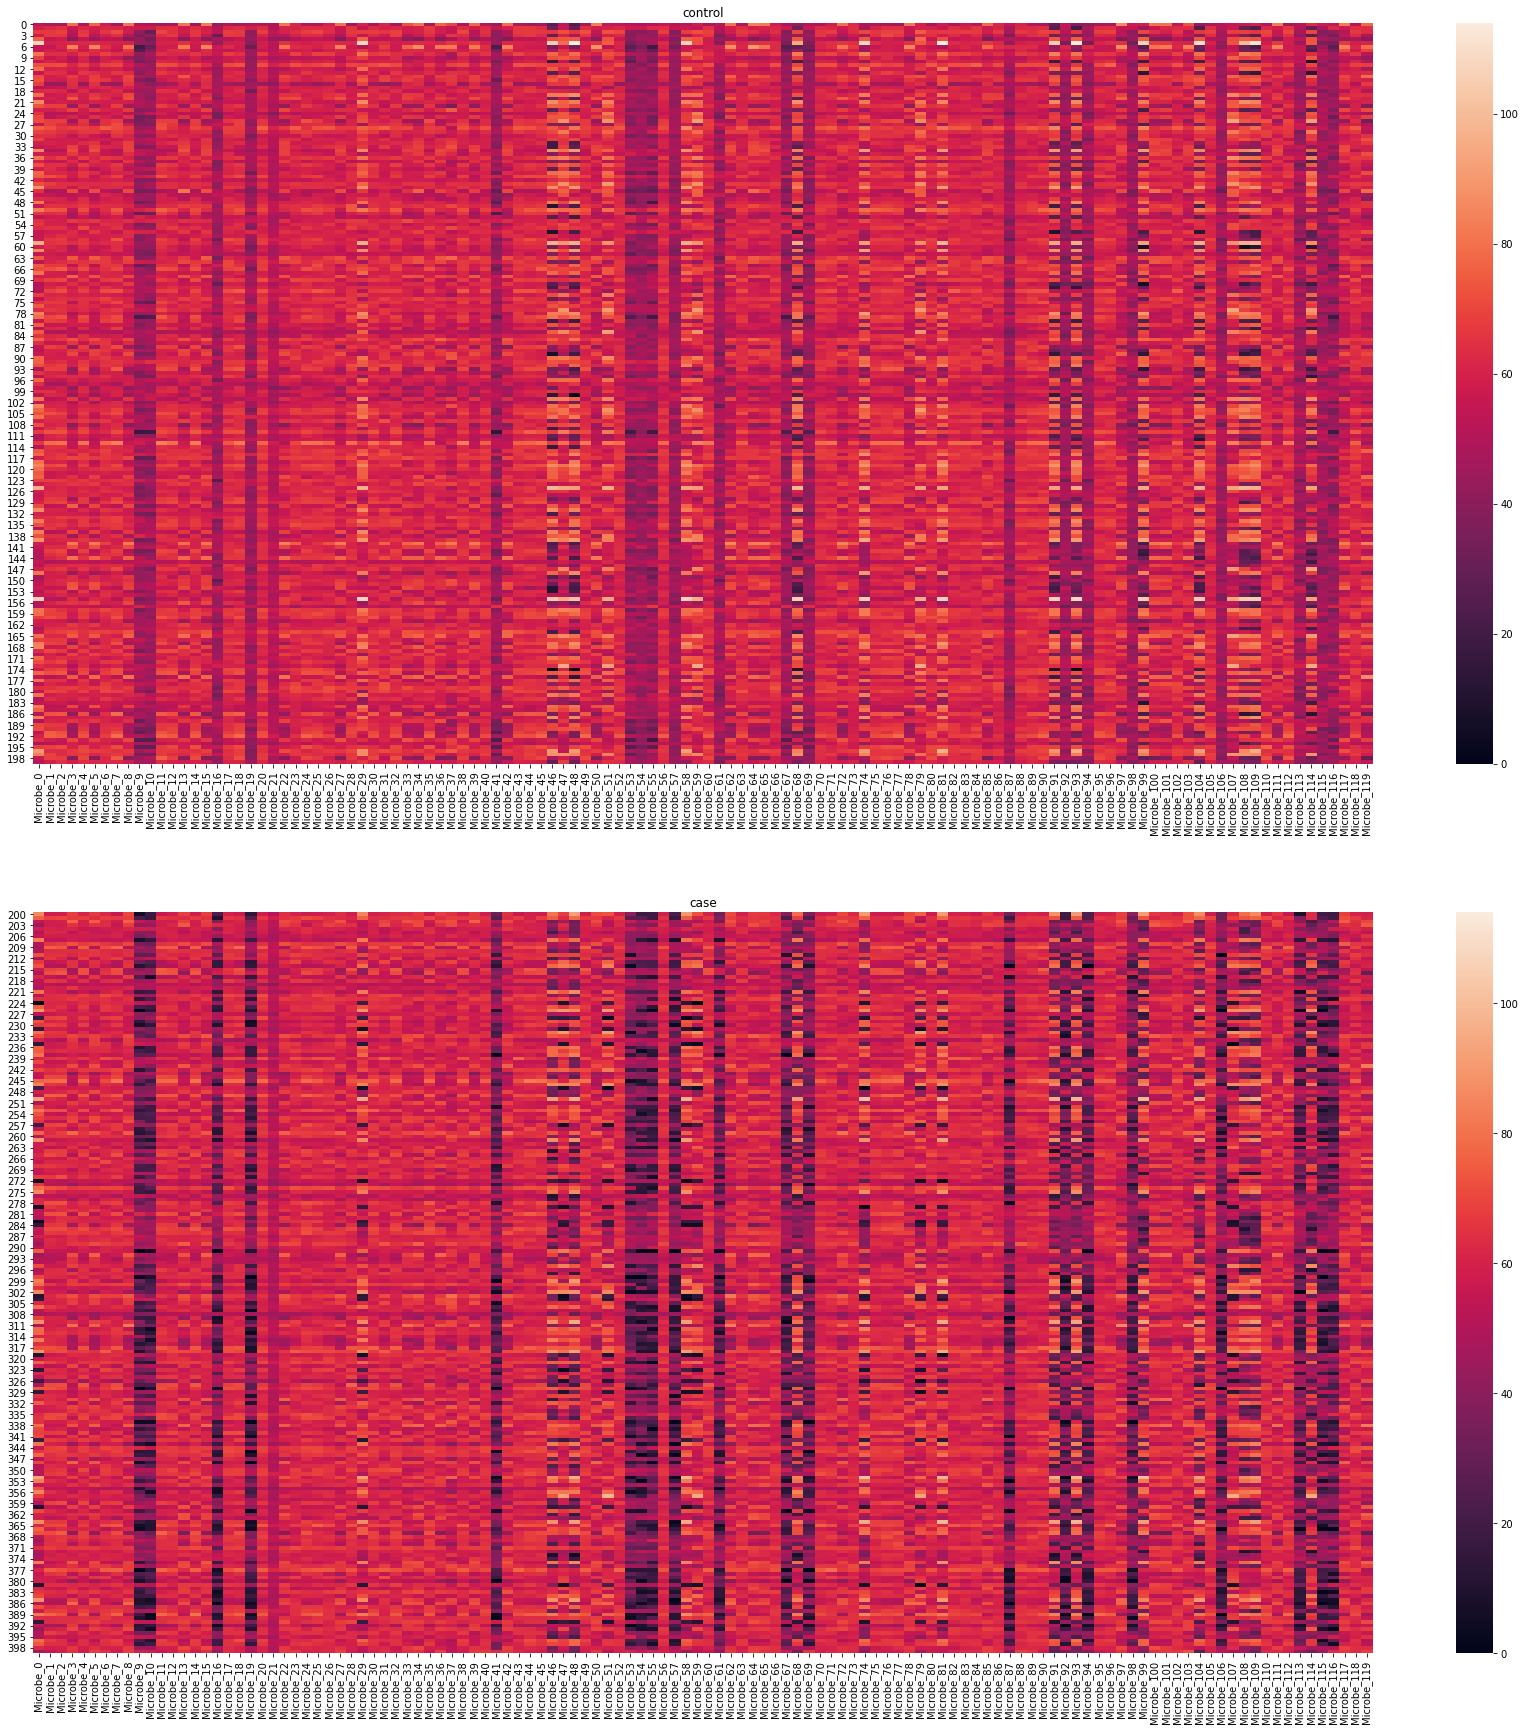

In [52]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(30,30))

min = df_abundance.drop('Group', axis=1).min().min()
max = df_abundance.drop('Group', axis=1).max().max()

heatmap(df_abundance[df_abundance.Group == 'control'].drop('Group', axis=1), ax=ax[0], vmin=min, vmax=max)
heatmap(df_abundance[df_abundance.Group == 'case'].drop('Group', axis=1), ax=ax[1], vmin=min, vmax=max)

ax[0].title.set_text('control')
ax[1].title.set_text('case')


some of the columns are noticably darker in the "case" heatmap than in the "control" heatmap which suggests that "case" subjects are lacking in those microbes compared to "control" subjects. The heatmaps are good at indicating which microbes tend to be more abumndant than others, and how the abundances differ between the two groups. These plots show general trends, but don't help with making precise conclusions, i.e. whether the difference between groups is statistically significant.

# Task 2

## Part 1

### 1.
The KS test is a non-parametric test. Non-parametric tests are used for variables with continuous distributions.

### 2.

In [54]:

def ks_sample(col):
    cases = col[df_case_mask]
    control = col[df_control_mask]
    return ks_2samp(control, cases)[1]

df_microbes = df_abundance.drop('Group', axis=1)
df_case_mask = df_abundance.Group == 'case'
df_control_mask = df_abundance.Group == 'control'

microbes_p_vals = df_microbes.apply(ks_sample, axis=0)
microbes_p_vals


Microbe_0      3.009847e-03
Microbe_1      8.655265e-01
Microbe_2      7.125821e-01
Microbe_3      2.205412e-01
Microbe_4      3.281154e-01
                   ...     
Microbe_115    3.133095e-21
Microbe_116    1.298543e-18
Microbe_117    1.779335e-01
Microbe_118    9.646522e-01
Microbe_119    9.238374e-01
Length: 120, dtype: float64

### 3.

In [133]:
idx = 0
microbe_zero_pval = microbes_p_vals[idx]
print(f"Microbe_{idx} p-value = {microbe_zero_pval:.3f}")

Microbe_0 p-value = 0.003


For each microbe $i$, let $D^{\text{case}}_i$ and $D^{\text{control}}_i$ be the distributions of abundance of microbe $i$ for case and control, respectively.

The null hypothesis for microbe $i$ is that $D^{\text{case}}_i = D^{\text{control}}_i$.

Using the 2-sample KS test for Microbe_0, we obtain a p-value of $.003 < \alpha=.05$, thus we reject that $D^{\text{case}}_0 = D^{\text{control}}_0$. That is, we reject that case and control abundance follow the same distribution for microbe 0.

### 4.

In [70]:
alphas = [0.1, 0.05, 0.01, 0.005, 0.001]

df_alphas = pd.DataFrame(index=alphas, columns=['count'])

for alpha in alphas:
    df_alphas.loc[alpha, 'count'] = (microbes_p_vals > alpha).sum()
    
df_alphas

,count
0.100,81
0.050,88
0.010,93
0.005,96
0.001,99


## Part 2

### 1.
In our context, a p-value of $.05$ means that there is a $5\%$ chance of observing a 2-sample KS test statistic - comparing the abundance distributions of case vs. control - at least as extreme as the one observed.

### 2.
Assuming the null hypothesis is true, the p-values are distributed uniform on $[0,1]$.

### 3.

In [71]:
N_microbes = len(microbes_p_vals)

for alpha in alphas:
    df_alphas.loc[alpha, 'count_unaltered'] = (1-alpha) * N_microbes
    
df_alphas

,count,count_unaltered
0.100,81,108.00
0.050,88,114.00
0.010,93,118.80
0.005,96,119.40
0.001,99,119.88


### 4.

#### 1.

In [95]:
p_vals_exp = np.random.uniform(size=(N_microbes,))

#### 2.

In [96]:
lg_p_vals_obs = -np.log10(microbes_p_vals)
lg_p_vals_exp = -np.log10(p_vals_exp)

#### 3.

In [97]:
lg_p_vals_obs = np.sort(lg_p_vals_obs)
lg_p_vals_exp = np.sort(lg_p_vals_exp)

#### 4. - 6.

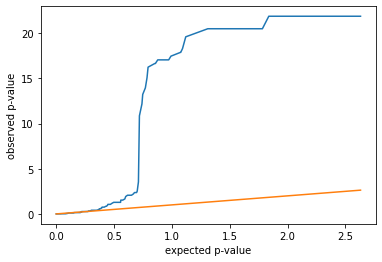

In [104]:
plt.plot(lg_p_vals_exp, lg_p_vals_obs)
plt.plot([0, lg_p_vals_exp.max()], [0, lg_p_vals_exp.max()])

plt.xlabel("expected p-value")
plt.ylabel("observed p-value")
plt.show()

### 5.

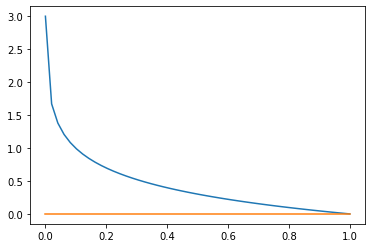

In [119]:
x = np.linspace(0.001, 1)
plt.plot(x, -np.log10(x))
plt.plot(x, [0]*len(x))

#### 1.
<!-- -log10 would keep all values positive while sparse the original data. The p-values we have are extremely small  
taking the -log10() of the p-values stratifies the points so that it can be better visualized. Most of the p-values are very small floating point values, so comparing the differences becomes more granular -->

We care about two ranges for our p-values: $[0,\alpha]$ and $[\alpha,1]$, as p-values in the first range indicate low statistical significance, while p-values in the second range indicate high significance. Since $\alpha$ is rather small, the first range is much tighter than the second, but in a sense, we want to be equally sensitive to each range. The $-\log_{10}$ function helps to achieve this by blowing up - and hence distinguishing - values that are smaller than $\alpha$, and almost-linearly scaling the values which are larger than $\alpha$, balancing the two ranges.

#### 2.
Since the x-y line does not align with the Q-Q plot, we have evidence that the observed p-values do not follow a uniform distribution, and hence the null hypothesis is unlikely to be true.

# Task 3

## Part 1

### 1.

In [28]:
def pca(df_abundance, n_components=None):
    pca = PCA(n_components=n_components, svd_solver='full')
    pca.fit(df_abundance)
    return pca

df_abundance_control = df_abundance[df_abundance.Group == 'control'].drop('Group', axis=1)
df_abundance_case = df_abundance[df_abundance.Group == 'case'].drop('Group', axis=1)

pca_control = pca(df_abundance_control)
vars_control = pca_control.explained_variance_ratio_
print(vars_control[:5])

pca_case = pca(df_abundance_case)
vars_case = pca_case.explained_variance_ratio_
print(vars_case[:5])

[0.51565968 0.17479997 0.10136051 0.04475184 0.03673141]
[0.56796183 0.10051867 0.08313546 0.0731463  0.0363506 ]


### 2.

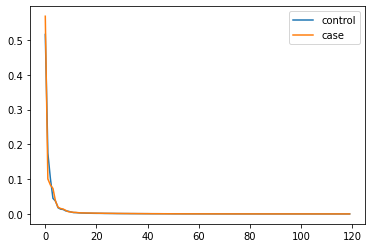

In [29]:
plt.plot(np.arange(len(vars_control)), vars_control)
plt.plot(np.arange(len(vars_case)), vars_case)

plt.legend(['control', 'case'])


In [41]:
def n_components_for_threshold(vars, thresh):
    return (1 - (np.cumsum(vars) >= thresh).astype(int)).sum() + 1

n_comp_control = n_components_for_threshold(vars_control, .8)
n_comp_case = n_components_for_threshold(vars_case, .8)

print('num principal components needed to explain 80% of data:')
print('control:', n_comp_control)
print('case:', n_comp_case)

num principal components needed to explain 80% of data:
control: 4
case: 4


### 3.

Text(0.5, 0, 'first principal component')

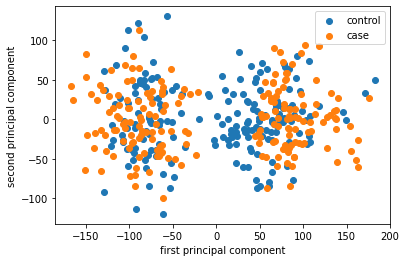

In [42]:
pca_control = pca(df_abundance_control, n_components=2)
abundance_control_reduced = pca_control.transform(df_abundance_control)
plt.scatter(abundance_control_reduced[:,0], abundance_control_reduced[:,1])

pca_case = pca(df_abundance_case, n_components=2)
abundance_case_reduced = pca_case.transform(df_abundance_case)
plt.scatter(abundance_case_reduced[:,0], abundance_case_reduced[:,1])

plt.legend(['control', 'case'])
plt.ylabel('second principal component')
plt.xlabel('first principal component')

We can see two distinct clusters in both the case and control data. The clusters seem a little closer together for control than for case, where they are clearly seperable.

## Part 2

### 1.

In [157]:
def plot(d, c, ax, df_abundance, cmap, cluster_method, name=None):
    pca_control = pca(df_abundance, n_components=d)
    df_abundance_reduced = pca_control.transform(df_abundance)
    if cluster_method == 'kmeans':
        kmeans = KMeans(n_clusters=c).fit(df_abundance_reduced)
        labels = kmeans.labels_
    elif cluster_method == 'gm':
        gm = GaussianMixture(n_components=c).fit(df_abundance_reduced)
        labels = gm.predict(df_abundance_reduced)
    else:
        raise Exception('bruh moment')
    cmap = matplotlib.colors.ListedColormap(cmap[10:,:-1])
    ax.scatter(
        *zip(df_abundance_reduced.T),
        c=labels, 
        cmap=cmap)
    ax.set_title(name)
    return labels

(array([ 83, 117]), array([100, 100]))

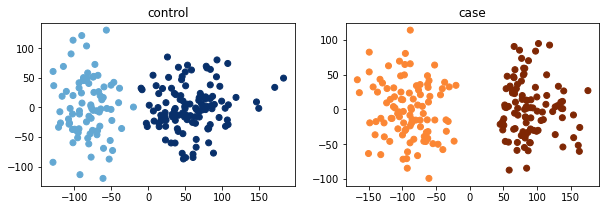

In [155]:
'''2D, 2 clusters, k-means'''
fig, axs = plt.subplots(ncols=2, figsize=(10,3))

control_labels = plot(2, 2, axs[0], df_abundance_control, matplotlib.cm.Blues(np.linspace(0,1,20)), 'kmeans', 'control')
case_labels = plot(2, 2, axs[1], df_abundance_case, matplotlib.cm.Oranges(np.linspace(0,1,20)), 'kmeans', 'case')
ax.legend(['control', 'case'])

_, control_cluster_counts = np.unique(control_labels, return_counts=True)
_, case_cluster_counts = np.unique(case_labels, return_counts=True)
control_cluster_counts, case_cluster_counts

(array([115,  47,  38]), array([100,  53,  47]))

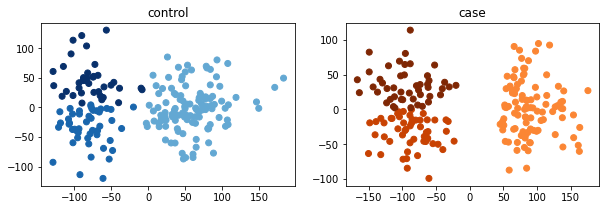

In [156]:
'''2D, 3 clusters, k-means'''
fig, axs = plt.subplots(ncols=2, figsize=(10,3))

control_labels = plot(2, 3, axs[0], df_abundance_control, matplotlib.cm.Blues(np.linspace(0,1,20)), 'kmeans', 'control')
case_labels = plot(2, 3, axs[1], df_abundance_case, matplotlib.cm.Oranges(np.linspace(0,1,20)), 'kmeans', 'case')
ax.legend(['control', 'case'])

_, control_cluster_counts = np.unique(control_labels, return_counts=True)
_, case_cluster_counts = np.unique(case_labels, return_counts=True)
control_cluster_counts, case_cluster_counts

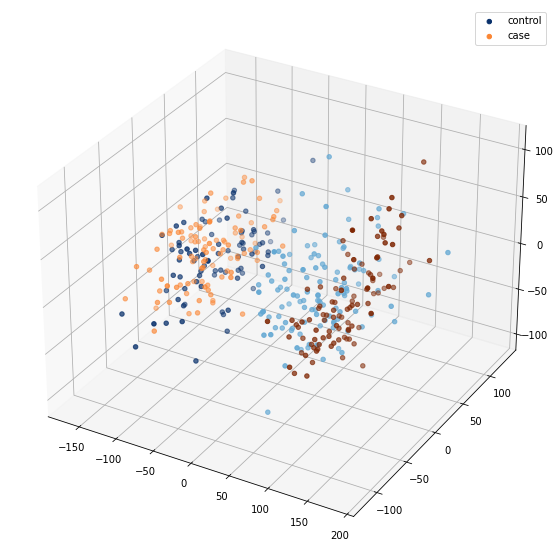

In [158]:
'''3D, 2 clusters, k-means'''
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

plot(3, 2, ax, df_abundance_control, matplotlib.cm.Blues(np.linspace(0,1,20)), 'kmeans')
plot(3, 2, ax, df_abundance_case, matplotlib.cm.Oranges(np.linspace(0,1,20)), 'kmeans')

plt.legend(['control', 'case'])

Based on our visualizations, it seems that two clusters are enough, and 2 principal components are also enough, as the 3D plot looks noisier than the 2D plot, particularly for control.

### 2.

(array([118,  82]), array([100, 100]))

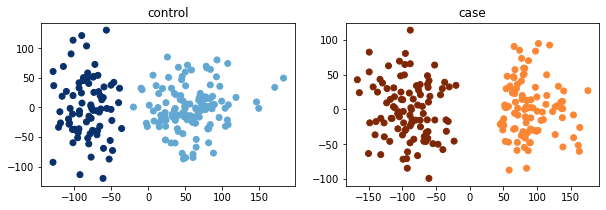

In [159]:
'''2D, 2 clusters, GM'''
fig, axs = plt.subplots(ncols=2, figsize=(10,3))

control_labels = plot(2, 2, axs[0], df_abundance_control, matplotlib.cm.Blues(np.linspace(0,1,20)), 'gm', 'control')
case_labels = plot(2, 2, axs[1], df_abundance_case, matplotlib.cm.Oranges(np.linspace(0,1,20)), 'gm', 'case')
ax.legend(['control', 'case'])

_, control_cluster_counts = np.unique(control_labels, return_counts=True)
_, case_cluster_counts = np.unique(case_labels, return_counts=True)
control_cluster_counts, case_cluster_counts

(array([ 49, 118,  33]), array([ 70, 100,  30]))

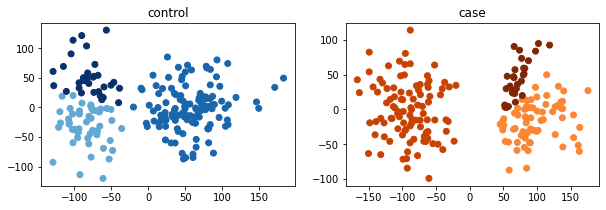

In [160]:
'''2D, 3 clusters, GM'''
fig, axs = plt.subplots(ncols=2, figsize=(10,3))

control_labels = plot(2, 3, axs[0], df_abundance_control, matplotlib.cm.Blues(np.linspace(0,1,20)), 'gm', 'control')
case_labels = plot(2, 3, axs[1], df_abundance_case, matplotlib.cm.Oranges(np.linspace(0,1,20)), 'gm', 'case')
ax.legend(['control', 'case'])

_, control_cluster_counts = np.unique(control_labels, return_counts=True)
_, case_cluster_counts = np.unique(case_labels, return_counts=True)
control_cluster_counts, case_cluster_counts

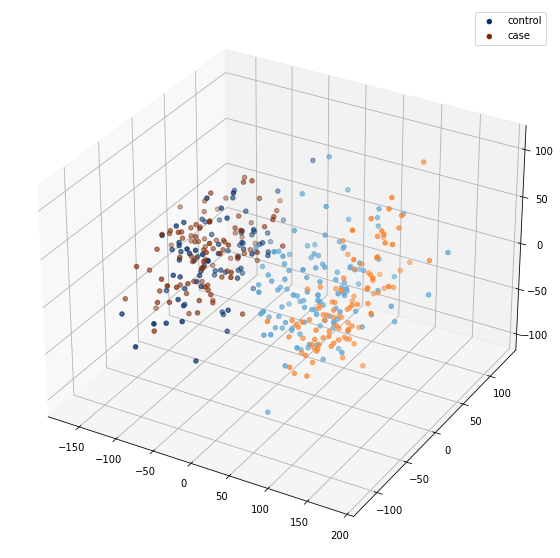

In [164]:
'''3D, 3 clusters, GM'''
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

plot(3, 2, ax, df_abundance_control, matplotlib.cm.Blues(np.linspace(0,1,20)), 'gm')
plot(3, 2, ax, df_abundance_case, matplotlib.cm.Oranges(np.linspace(0,1,20)), 'gm')

ax.legend(['control', 'case'])

### 3.

The results are very similar for k-means and Gaussian mixture. Two clusters in two dimensions seems to be the most useful representation of the data. 3 clusters seems like it causes over-fitting, and 3D looks noisier. As far as choosing a clustering method, k-means and Gaussian mixture perform virtually identically in 2d with 2 clusters (only one point is classified differently), thus we will stick with k-means, the slightly simpler model.

### 4.

The clusters represent subpopulations of the microbes.

### 5.

Maybe if we were able to visualize in higher dimensions then we would conclude that more clusters are fitting, but our vision limits us to three dimensions.

## Part 3

### 1.